## SNN assignment
### Name: Hao wan, G-number: G01507851

## Part 1: Encoding/Decoding

In [ ]:
pip install snntorch

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import snntorch as snn
import snntorch.spikegen as spikegen
import matplotlib.pyplot as plt

In [2]:
# Training Parameters
batch_size=128
data_path='/tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

In [3]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# Define a transform
transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)

In [4]:
def compute_RMSE(signal1: torch.Tensor, signal2: torch.Tensor) -> torch.Tensor:
    
    return torch.sqrt(torch.mean((signal1 - signal2) ** 2))

def compute_AFR(spike_train: torch.Tensor) -> torch.Tensor:
    
    return torch.mean(spike_train.float())

In [5]:
mnist_digits = {}
for image, label in mnist_train:
    if label not in mnist_digits:
        mnist_digits[label] = image.squeeze(0)
    if len(mnist_digits) == 10:
        break

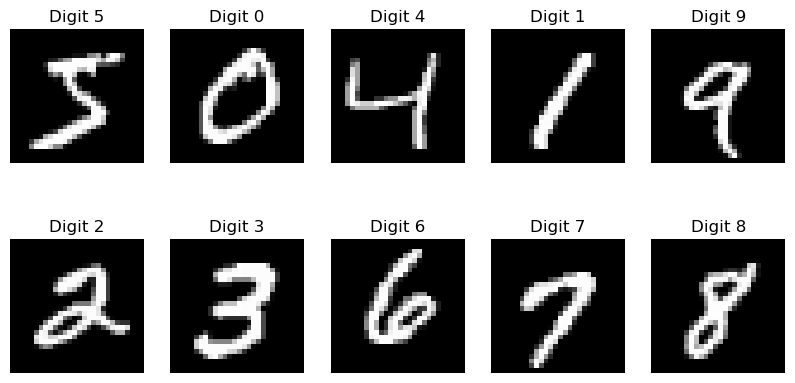

In [13]:
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, (digit, img) in enumerate(mnist_digits.items()):
    ax = axes[i // 5, i % 5]
    ax.imshow(img.numpy(), cmap='gray')
    ax.set_title(f"Digit {digit}")
    ax.axis('off')
plt.show()

In [ ]:
time_steps = 50  
gain_low = 0.33  
spike_trains = {}
for digit, img in mnist_digits.items():
    spike_trains[digit] = {
        "rate_coding": spikegen.rate(img, num_steps=time_steps),
        "latency_coding": spikegen.latency(img, num_steps=time_steps)
    }
afr_results_rate = {digit: compute_AFR(spike_trains[digit]["rate_coding"]) for digit in spike_trains}
afr_results_latency = {digit: compute_AFR(spike_trains[digit]["latency_coding"]) for digit in spike_trains}

In [19]:
print(afr_results_rate)

{5: tensor(0.1367), 0: tensor(0.1566), 4: tensor(0.0973), 1: tensor(0.0861), 9: tensor(0.1153), 2: tensor(0.1477), 3: tensor(0.1792), 6: tensor(0.1431), 7: tensor(0.1266), 8: tensor(0.1364)}


In [20]:
print(afr_results_latency)

{5: tensor(0.0200), 0: tensor(0.0200), 4: tensor(0.0200), 1: tensor(0.0200), 9: tensor(0.0200), 2: tensor(0.0200), 3: tensor(0.0200), 6: tensor(0.0200), 7: tensor(0.0200), 8: tensor(0.0200)}


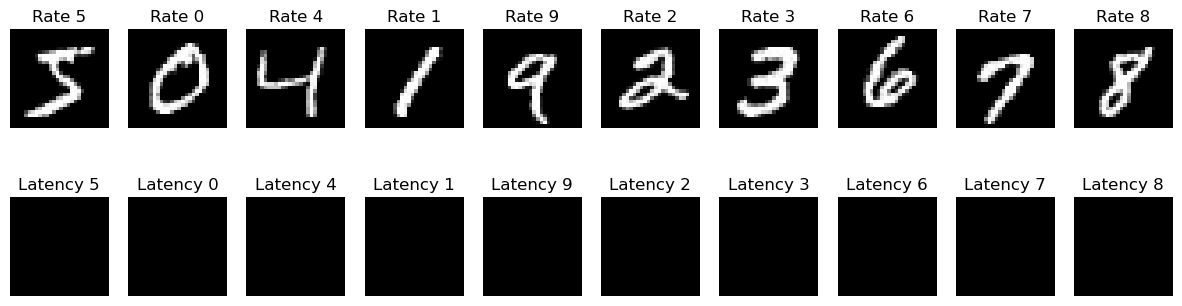

In [21]:
fig, axes = plt.subplots(2, 10, figsize=(15, 4))
for i, (digit, spikes) in enumerate(spike_trains.items()):
    # Rate coding
    ax1 = axes[0, i]
    ax1.imshow(spikes["rate_coding"].sum(dim=0).numpy(), cmap='gray')
    ax1.set_title(f"Rate {digit}")
    ax1.axis('off')

    # Latency coding
    ax2 = axes[1, i]
    ax2.imshow(spikes["latency_coding"].sum(dim=0).numpy(), cmap='gray')
    ax2.set_title(f"Latency {digit}")
    ax2.axis('off')

plt.show()

In [7]:
rmse_results = {}
rmse_results_low_gain = {}
for digit, spikes in spike_trains.items():
   
    reconstructed = torch.mean(spikes["rate_coding"], dim=0)
    reconstructed_low = torch.mean(spikegen.rate(mnist_digits[digit], num_steps=time_steps, gain=gain_low), dim=0)
   
    rmse_results[digit] = compute_RMSE(reconstructed, mnist_digits[digit])
    rmse_results_low_gain[digit] = compute_RMSE(reconstructed_low, mnist_digits[digit])

In [8]:
for digit in range(10):
    print(f"Digit {digit} - AFR: {afr_results[digit].item():.4f}, RMSE: {rmse_results[digit].item():.4f}, RMSE (Gain 0.33): {rmse_results_low_gain[digit].item():.4f}")


Digit 0 - AFR: 0.1552, RMSE: 0.0234, RMSE (Gain 0.33): 0.2449
Digit 1 - AFR: 0.0856, RMSE: 0.0175, RMSE (Gain 0.33): 0.1850
Digit 2 - AFR: 0.1476, RMSE: 0.0238, RMSE (Gain 0.33): 0.2392
Digit 3 - AFR: 0.1793, RMSE: 0.0199, RMSE (Gain 0.33): 0.2682
Digit 4 - AFR: 0.0966, RMSE: 0.0203, RMSE (Gain 0.33): 0.1866
Digit 5 - AFR: 0.1372, RMSE: 0.0224, RMSE (Gain 0.33): 0.2288
Digit 6 - AFR: 0.1418, RMSE: 0.0245, RMSE (Gain 0.33): 0.2302
Digit 7 - AFR: 0.1272, RMSE: 0.0188, RMSE (Gain 0.33): 0.2230
Digit 8 - AFR: 0.1353, RMSE: 0.0204, RMSE (Gain 0.33): 0.2308
Digit 9 - AFR: 0.1149, RMSE: 0.0209, RMSE (Gain 0.33): 0.2118


## Part 2: The LIF Neuron

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import snntorch as snn
import snntorch.spikegen as spikegen
import matplotlib.pyplot as plt

In [11]:
# First set with R = 2.0, C = 1.0, T = 1.5
def lif_neuron(input_signal, time_steps=100, threshold=1.5, resistance=3.0, capacitance=2.0):
    
    voltage = torch.zeros(time_steps)
    spikes = torch.zeros(time_steps)
    tau = resistance * capacitance
    
    for t in range(1, time_steps):
        dv = (-voltage[t-1] + resistance * input_signal[t-1]) / tau
        voltage[t] = voltage[t-1] + dv
        
        if voltage[t] >= threshold:
            spikes[t] = 1.0
            voltage[t] -= threshold  # Reset after spike
    
    return voltage, spikes

In [12]:
time_steps = 100
test_signal1 = torch.zeros(time_steps)
test_signal2 = torch.zeros(time_steps)
test_signal3 = torch.zeros(time_steps)
test_signal1[0] = 1.0  # High signal at t=0
test_signal2[25:26] = 1.0  # Low switching to high at t=25
test_signal3[15:30] = 2.0  # Pulse from t=15 to t=30



In [13]:
voltage1, spikes1 = lif_neuron(test_signal1)

In [14]:
voltage2, spikes2 = lif_neuron(test_signal2)

In [15]:
voltage3, spikes3 = lif_neuron(test_signal3)

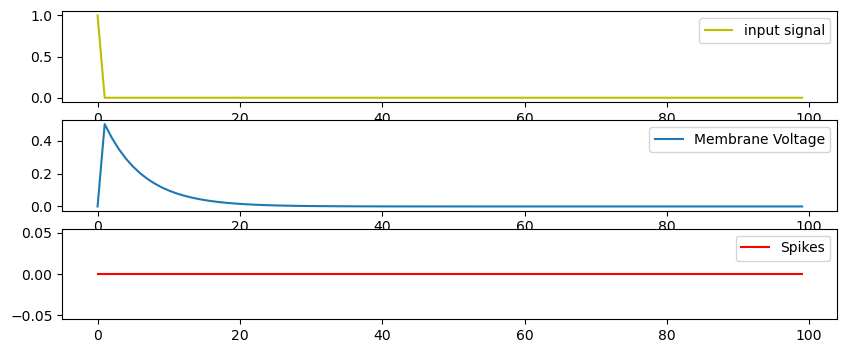

In [16]:
plt.figure(figsize=(10, 4))
plt.subplot(3, 1, 1)
plt.plot(test_signal1.numpy(), label='input signal', color='y')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(voltage1.numpy(), label='Membrane Voltage')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(spikes1.numpy(), label='Spikes', color='r')
plt.legend()
plt.show()

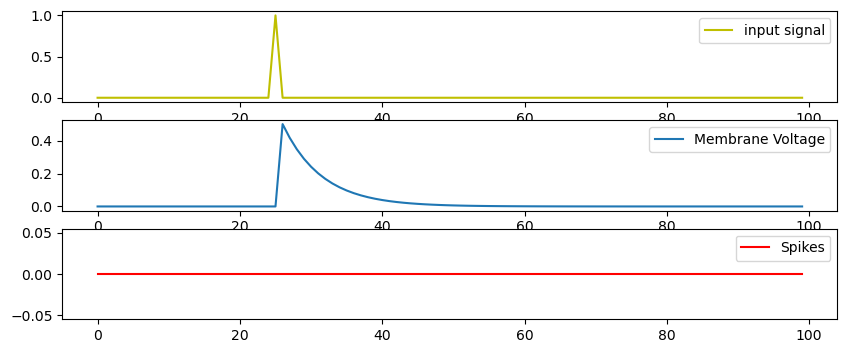

In [17]:
plt.figure(figsize=(10, 4))
plt.subplot(3, 1, 1)
plt.plot(test_signal2.numpy(), label='input signal', color='y')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(voltage2.numpy(), label='Membrane Voltage')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(spikes2.numpy(), label='Spikes', color='r')
plt.legend()
plt.show()

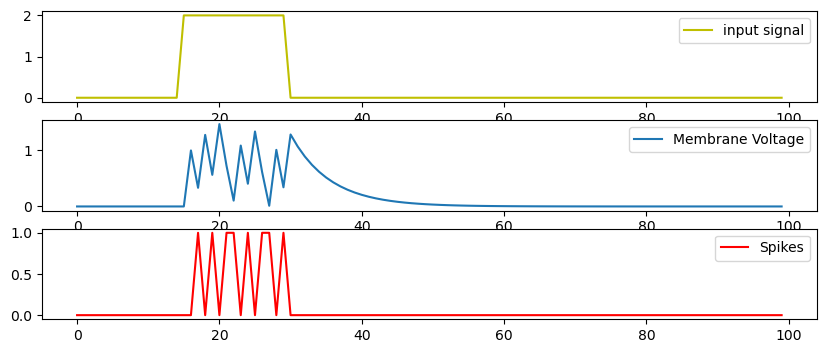

In [18]:
plt.figure(figsize=(10, 4))
plt.subplot(3, 1, 1)
plt.plot(test_signal3.numpy(), label='input signal', color='y')
plt.legend()


plt.subplot(3, 1, 2)
plt.plot(voltage3.numpy(), label='Membrane Voltage')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(spikes3.numpy(), label='Spikes', color='r')
plt.legend()
plt.show()